# exp6. 프로젝트 : 네이버 영화리뷰 감성분석

네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus
https://github.com/e9t/nsmc

### 0. 루브릭
***

### 1. 데이터 준비와 확인
***

In [14]:
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages')


# 데이터를 읽어봅시다. 
train_data = pd.read_table('D:/project/sentiment_classification/data/nsmc-master/ratings_train.txt')
test_data = pd.read_table('D:/project/sentiment_classification/data/nsmc-master/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
print(train_data.document[0])
print(train_data.label[0])

train_data.info()
train_data.describe()

아 더빙.. 진짜 짜증나네요 목소리
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,label
count,1.500000e+05,150000.000000
mean,6.743533e+06,0.498847
std,2.919051e+06,0.500000
min,3.300000e+01,0.000000
25%,4.766881e+06,0.000000
50%,7.526840e+06,0.000000
75%,9.249435e+06,1.000000
max,1.027815e+07,1.000000


In [16]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


### 2. 데이터로더 구성
***
nsmc 데이터셋은 IMDB에서 제공했던 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리가 없다.  
가공되지 않은 텍스트 파일들을 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작함

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [17]:
# 중복 데이터 확인 
# nunique() : 중복되지 않은 데이터의 갯수 
print(train_data['document'].nunique())  #146182


146182


In [18]:
# 결측치 확인 
print(train_data.isnull().values.any()) # True 
print(test_data.isnull().values.any()) # True 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

True
True
id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [19]:
from eunjeon import Mecab # MeCab 오류로 eunjeon 사용
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [20]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [21]:
print(word_to_index['정말'])  # 정말은 인덱스 29

29


In [22]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공
***

#### 3.1 데이터셋 내 문장 길이 분포

In [23]:
# 전체 데이터 셋 통합 
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.972842084785936
문장길이 최대 :  116
문장길이 표준편차 :  12.843357707480491


#### 3.2 적절한 최대 문장 길이 지정

In [24]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))

pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


#### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [25]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, 
                                                     value=word_to_index['<PAD>'],
                                                     padding='pre', # 혹은 'pre'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test, 
                                                    value=word_to_index['<PAD>'],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4. 모델 구성 및 validation set 구성
***

#### 4.1 모델1 RNN 모델 설계

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

Cnn_model = keras.Sequential()
Cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.MaxPooling1D(5))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.GlobalMaxPooling1D())
Cnn_model.add(keras.layers.Dense(8, activation='relu'))
Cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          1808      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                

#### 4.3 모델3 Embed 모델


In [27]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


#### 4.4 validation set 구성

In [28]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, 
                                                                  test_size = 0.2, 
                                                                  shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(116945, 41) (116945,)
(29237, 41) (29237,)


### 5. 모델 훈련 개시

In [29]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = rnn_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/8
229/229 - 22s - loss: 0.5936 - accuracy: 0.7504 - val_loss: 0.4478 - val_accuracy: 0.8114 - 22s/epoch - 97ms/step
Epoch 2/8
229/229 - 21s - loss: 0.3860 - accuracy: 0.8336 - val_loss: 0.3703 - val_accuracy: 0.8392 - 21s/epoch - 91ms/step
Epoch 3/8
229/229 - 23s - loss: 0.3317 - accuracy: 0.8582 - val_loss: 0.3557 - val_accuracy: 0.8450 - 23s/epoch - 100ms/step
Epoch 4/8
229/229 - 23s - loss: 0.3027 - accuracy: 0.8731 - val_loss: 0.3529 - val_accuracy: 0.8472 - 23s/epoch - 100ms/step
Epoch 5/8
229/229 - 21s - loss: 0.2814 - accuracy: 0.8847 - val_loss: 0.3547 - val_accuracy: 0.8490 - 21s/epoch - 93ms/step
Epoch 6/8
229/229 - 21s - loss: 0.2642 - accuracy: 0.8930 - val_loss: 0.3591 - val_accuracy: 0.8482 - 21s/epoch - 91ms/step
Epoch 7/8
229/229 - 18s - loss: 0.2492 - accuracy: 0.9001 - val_loss: 0.3666 - val_accuracy: 0.8477 - 18s/epoch - 78ms/step
Epoch 8/8
229/229 - 17s - loss: 0.2364 - accuracy: 0.9066 - val_loss: 0.3741 - val_accuracy: 0.8471 - 17s/epoch - 75ms/step


In [30]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6. Loss, Accuracy 그래프 시각화

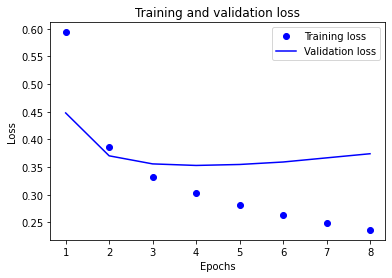

In [31]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

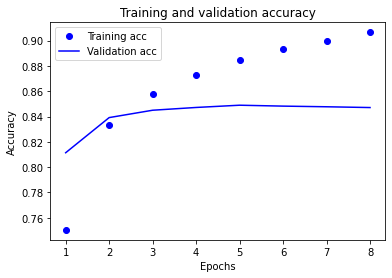

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

epochs는 5회면 

### 7. 학습된 Embedding 레이어 분석

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

Pre-trained word vectors of 30+ languages  
https://github.com/Kyubyong/wordvectors  

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

### 9. 느낀점